In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
data1 = pd.read_csv("/content/Arumbakkam, Chennai - TNPCB.csv")
data2 = pd.read_csv("/content/Manali, Chennai - CPCB.csv")
data3 = pd.read_csv("/content/Perungudi, Chennai - TNPCB.csv")
data4 = pd.read_csv("/content/Velachery Res. Area, Chennai - CPCB.csv")
data5 = pd.read_csv("/content/Kodungaiyur, Chennai - TNPCB.csv")

In [ ]:
data1.tail()

,From Date,To Date,PM2.5,NO2,SO2,Temp,WS,WD,SR,RH
35132,31-12-2024 23:00,31-12-2024 23:15,80.0,5.2,5.0,28.0,1.8,NaN,57.0,96.0
35133,31-12-2024 23:15,31-12-2024 23:30,80.0,7.7,4.9,28.0,1.4,NaN,57.0,96.0
35134,31-12-2024 23:30,31-12-2024 23:45,80.0,8.1,5.1,28.1,1.8,NaN,57.0,96.0
35135,31-12-2024 23:45,01-01-2025 00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35136,01-01-2025 00:00,01-01-2025 00:00,77.0,9.3,5.4,28.1,2.3,NaN,57.0,96.0


In [ ]:
data1 = data1[['To Date', 'PM2.5']]
data2 = data2[['To Date', 'PM2.5']]
data3 = data3[['To Date', 'PM2.5']]
data4 = data4[['To Date', 'PM2.5']]
data5 = data5[['To Date', 'PM2.5']]

In [ ]:
data1['To Date'] = pd.to_datetime(data1['To Date'], format='%d-%m-%Y %H:%M')
data2['To Date'] = pd.to_datetime(data2['To Date'], format='%d-%m-%Y %H:%M')
data3['To Date'] = pd.to_datetime(data3['To Date'], format='%d-%m-%Y %H:%M')
data4['To Date'] = pd.to_datetime(data4['To Date'], format='%d-%m-%Y %H:%M')
data5['To Date'] = pd.to_datetime(data5['To Date'], format='%d-%m-%Y %H:%M')

In [ ]:
data1 = data1[:-1]
data2 = data2[:-1]
data3 = data3[:-1]
data4 = data4[:-1]
data5 = data5[:-1]

In [ ]:
for i in range(1, 6):
    df = globals()[f'data{i}']
    df = df.set_index('To Date').sort_index()
    df[['PM2.5']] = df[['PM2.5']].interpolate(method='time')
    df[['PM2.5']] = df[['PM2.5']].fillna(method='ffill').fillna(method='bfill')
    globals()[f'data{i}'] = df

<ipython-input-12-990b17737739>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[['PM2.5']] = df[['PM2.5']].fillna(method='ffill').fillna(method='bfill')
<ipython-input-12-990b17737739>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[['PM2.5']] = df[['PM2.5']].fillna(method='ffill').fillna(method='bfill')
<ipython-input-12-990b17737739>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[['PM2.5']] = df[['PM2.5']].fillna(method='ffill').fillna(method='bfill')
<ipython-input-12-990b17737739>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[['PM2.5']] = df[['PM2.5']].fillna(method='ffill').fillna(method='bfill')
<ipy

In [ ]:
data4.tail()

,PM2.5
To Date,
2024-12-31 23:00:00,89.35
2024-12-31 23:15:00,107.83
2024-12-31 23:30:00,127.13
2024-12-31 23:45:00,127.13
2025-01-01 00:00:00,127.13


In [ ]:
# Rename columns for data1 to data4
for i in range(1, 5):
    df = globals()[f'data{i}']
    df.columns = [f'{col}_{i}' for col in df.columns]
    globals()[f'data{i}'] = df

# Join all DataFrames on 'To Date' index
df = data5.join([data1,data2, data3, data4], how='inner')

# Optional: sort index if needed
df = df.sort_index()

In [ ]:
df.head()

,PM2.5,PM2.5_1,PM2.5_2,PM2.5_3,PM2.5_4
To Date,,,,,
2024-01-01 00:15:00,29.0,80.0,59.42,58.0,22.75
2024-01-01 00:30:00,29.0,80.0,61.94,58.0,29.47
2024-01-01 00:45:00,29.0,80.0,64.94,58.0,30.22
2024-01-01 01:00:00,42.0,203.0,64.94,129.0,30.22
2024-01-01 01:15:00,42.0,203.0,64.94,129.0,30.22


In [ ]:
df.isna().sum()

,0
PM2.5,0
PM2.5_1,0
PM2.5_2,0
PM2.5_3,0
PM2.5_4,0


In [ ]:
df.reset_index(inplace=True)

In [ ]:
df['Day'] = df['To Date'].dt.day
df['Hour'] = df['To Date'].dt.hour
df['Quadrant'] = df['To Date'].dt.minute // 15

In [ ]:
features = ['PM2.5','PM2.5_1','PM2.5_2',
            'PM2.5_3','PM2.5_4', 'Day', 'Hour', 'Quadrant']

In [ ]:
data = df[features]

In [ ]:
import numpy as np

def create_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(n_steps_in, len(data) - n_steps_out + 1):
        # Use .iloc to slice the DataFrame rows correctly
        X.append(data.iloc[i - n_steps_in:i, :].values)  # Convert slice to NumPy array
        y.append(data.iloc[i:i + n_steps_out, 0].values)  # Get target variable (PM2.5)
    return np.array(X), np.array(y)

n_steps_in = 12  # Input time steps
n_steps_out = 4  # Output time steps (multi-step forecast)

# Create sequences
X_raw, y_raw = create_sequences(data, n_steps_in, n_steps_out)


In [ ]:
train_size = int(0.8 * len(X_raw))
X_train_raw, X_test_raw = X_raw[:train_size], X_raw[train_size:]
y_train_raw, y_test_raw = y_raw[:train_size], y_raw[train_size:]

# Initialize scaler for input features
scaler = MinMaxScaler()

# Reshape X_train_raw and X_test_raw to be 2D for scaling (samples, features)
X_train_reshaped = X_train_raw.reshape(-1, X_raw.shape[2])  # Flatten for scaling
scaler.fit(X_train_reshaped)

# Apply scaling to input data
X_train = scaler.transform(X_train_reshaped).reshape(X_train_raw.shape)
X_test = scaler.transform(X_test_raw.reshape(-1, X_raw.shape[2])).reshape(X_test_raw.shape)

y_scaler = MinMaxScaler()

# Reshape and fit the scaler to the targets (the multi-step values)
y_train_reshaped = y_train_raw.reshape(-1, n_steps_out)
y_test_reshaped = y_test_raw.reshape(-1, n_steps_out)

# Fit the scaler for the targets
y_scaler.fit(y_train_reshaped)

# Transform the targets
y_train = y_scaler.transform(y_train_reshaped)
y_test = y_scaler.transform(y_test_reshaped)

In [ ]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(n_steps_in, X_train.shape[2])),  # n_steps_in is the input time steps
    LSTM(32),
    Dense(n_steps_out)  # Output layer to predict 'n_steps_out' values
])

model.compile(optimizer='adam', loss='mae')

# Early stopping and learning rate reduction
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)

# Fit the model
history = model.fit(
    X_train, y_train,  # Note that y_train is already multi-step
    epochs=40,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


703/703 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.0239 - val_loss: 0.0146 - learning_rate: 0.0010
Epoch 2/40
703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0166 - val_loss: 0.0139 - learning_rate: 0.0010
Epoch 3/40
703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0137 - val_loss: 0.0112 - learning_rate: 0.0010
Epoch 4/40
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0128 - val_loss: 0.0104 - learning_rate: 0.0010
Epoch 5/40
703/703 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0125 - val_loss: 0.0103 - learning_rate: 0.0010
Epoch 6/40
703/703 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0121 - val_loss: 0.0102 - learning_rate: 0.0010
Epoch 7/40
703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0121 - val_loss: 0.0102 - learning_rate: 0.0010
Epoch 8/40
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0120 - val_loss: 0.0099 - learning_rate: 0.0010
Epoch 9/40
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0119 - val_loss: 0.0102 - learning_rate: 0.0010
Epoch 

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

pm25_index = features.index('PM2.5')

# Inverse transform the predicted values (multi-step)
y_pred_inv = scaler.inverse_transform(
    np.hstack((y_pred, np.zeros((len(y_pred), len(features) - n_steps_out))))  # Adjust for multi-step forecast
)[:, pm25_index]

# Inverse transform the actual values (multi-step)
y_test_inv = scaler.inverse_transform(
    np.hstack((y_test, np.zeros((len(y_test), n_steps_out))))  # Adjust for multi-step forecast
)[:, pm25_index]

# Calculate MAE, RMSE, R² for multi-step forecast
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)

# Print final metrics
print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)

220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
MAE: 1.2932559977810971
RMSE: 6.333557176749731
R²: 0.8734516872934783


220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


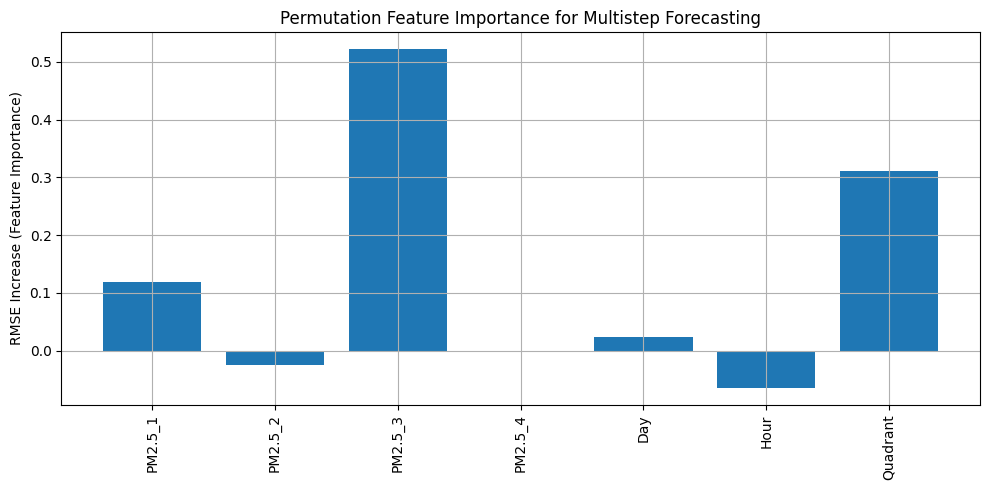

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Function to calculate permutation feature importance for multistep forecast
def permutation_feature_importance_multistep(model, X_original, y_true, scaler, features, pm25_index, n_steps_out):
    # Get base predictions
    base_pred = model.predict(X_original)
    base_pred_inv = scaler.inverse_transform(np.hstack((base_pred, np.zeros((len(base_pred), len(features) - n_steps_out)))))[:, pm25_index]
    y_true_inv = scaler.inverse_transform(np.hstack((y_true, np.zeros((len(y_true), n_steps_out)))))[:, pm25_index]
    base_rmse = np.sqrt(mean_squared_error(y_true_inv, base_pred_inv))

    importances = []

    # Iterate over features and shuffle them one by one to compute importance
    for i in range(1, X_original.shape[2]):  # Skip the target (PM2.5) feature
        X_permuted = X_original.copy()
        X_permuted[:, :, i] = np.random.permutation(X_permuted[:, :, i])  # Shuffle the i-th feature

        # Get predictions after shuffling
        permuted_pred = model.predict(X_permuted)
        permuted_pred_inv = scaler.inverse_transform(np.hstack((permuted_pred, np.zeros((len(permuted_pred), len(features) - n_steps_out)))))[:, pm25_index]

        # Calculate RMSE for permuted predictions
        permuted_rmse = np.sqrt(mean_squared_error(y_true_inv, permuted_pred_inv))

        # Store importance (RMSE increase)
        importances.append(permuted_rmse - base_rmse)

    return importances

# Calculate feature importances
importances = permutation_feature_importance_multistep(model, X_test, y_test, scaler, features, pm25_index, n_steps_out)

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.bar(features[1:], importances)  # Exclude PM2.5 as it's the target
plt.ylabel("RMSE Increase (Feature Importance)")
plt.title("Permutation Feature Importance for Multistep Forecasting")
plt.xticks(rotation=90)  # Rotate feature names for better visibility
plt.grid(True)
plt.tight_layout()
plt.show()
